# Data Augmentation Process workflow

### 0. pre set
### 1. get user uploaded image data & annotation file
### 2. generate mask image(or extract bbox array) from annotation file and mapping with image file name
### 3. data augmentation(using albumbentation) each image & mask or box
### 4. check quality of augmented data 
### 5. save all images and coco-type annotation file(as 1 .json file) generated from augmented mask images to local

In [2]:
import albumentations as A
import random
import cv2
import numpy as np
import os
%matplotlib inline
#The line above is necesary to show Matplotlib's plots inside a Jupyter Notebook
from matplotlib import pyplot as plt

from glob import glob
import json
import shutil

import pycocotools
from pycocotools.coco import COCO

import requests 
from PIL import Image

## 0. pre set

In [3]:
#사용자가 라벨 작업을 한 이미지 10장과 각각의 라벨 정보를 담고있는 .json 파일 1개가 있다고 가정
# coco val2017 에서 사람이 있는 인덱스 10개 추출 , 해당하는 이미지 현재 디렉토리로 복사 & .json 파일 저장
json_path = "/home/tbelldev/workspace/autoLabeling/dataset/COCO_download/annotations/instances_val2017.json"
val_image_path = "/home/tbelldev/workspace/autoLabeling/dataset/coco/images/val/"
pwd = "/home/tbelldev/workspace/autoLabeling/api_test/user_dataset_sample/"

def coco_style_gen():
    files = {}
    files['info'] = {"year": 2022, "version": "1.0", "description": "Person Segmentation", "date_created": "0927"}
    files['licenses'] = [{'id': 1,
        'name': 'GNU General Public License v3.0',
        'url': 'test'}]
    files["type"] = "instances"
    files['categories'] = []
    files["annotations"] = []
    files['images'] = []
    return files

with open(json_path, 'r') as f:

    json_data = json.load(f)

# get img_id which includes person(1) category
person_image_id_list = []
for i in range(len(json_data["annotations"])):
    # if str(json_data["annotations"][ i]["category_id"]) == str(1):
    person_image_id_list.append(json_data["annotations"][i]["image_id"])
    if len(person_image_id_list) == 10 :
        break

# create empty coco form for extraction
json_data_coco = coco_style_gen()

coco_annotation = COCO(json_path)
cat_ids_list = []
for i in range(len(person_image_id_list)):
    # get anno info from image_id extracted above and filter person class
    ann_ids = coco_annotation.getAnnIds(imgIds=[person_image_id_list[i]], iscrowd=None)
    anns = coco_annotation.loadAnns(ann_ids)
    
    for j in range(len(anns)):
        # if anns[j]["category_id"] == 1: 
        json_data_coco["annotations"].append(anns[j])
        cat_ids_list.append(anns[j]["category_id"])
    
    # get image info from image_id extracted above and append to image field
    img_info = coco_annotation.loadImgs([person_image_id_list[i]])[0]
    json_data_coco["images"].append(img_info)
    


    # get origin image from image_id extracted above and save to local
    img_file_name = img_info["file_name"]
    img_url = img_info["coco_url"]
    im = Image.open(requests.get(img_url, stream=True).raw)
    cv2.imwrite(pwd+img_file_name,cv2.cvtColor(np.asarray(im),cv2.COLOR_BGR2RGB))            

#get category field from each annotation fields and map with original file
# print(cat_ids_list)
cat_ids_list = list(set(cat_ids_list))
cats = coco_annotation.loadCats(coco_annotation.getCatIds())
cat_ids_list.sort()
for i in range(len(cat_ids_list)):
    for j in range(len(cats)):
        if cat_ids_list[i] == cats[j]["id"] : json_data_coco["categories"].append({"id":cat_ids_list[i],
                                                                                   "name":cats[j]["name"]})

with open(pwd+"anno_with_multi_classes_10_images.json", 'w', encoding='utf-8') as make_file:
    json.dump(json_data_coco, make_file)


loading annotations into memory...
Done (t=1.21s)
creating index...
index created!


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


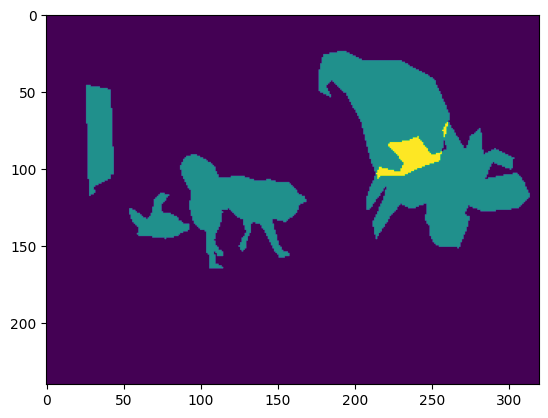

In [4]:
val_image_path = "/home/tbelldev/workspace/autoLabeling/api_test/user_dataset_sample/"
coco_annotation = COCO(val_image_path+"anno_with_multi_classes_10_images.json")
ann_ids = coco_annotation.getAnnIds(imgIds=[404484], iscrowd=None)
anns = coco_annotation.loadAnns(ann_ids)
mask = np.zeros(cv2.imread(val_image_path+"000000404484.jpg",0).shape)
for i in range(len(anns)):
    mask += coco_annotation.annToMask(anns[i])
binary_mask =  mask * 255.

plt.imshow(binary_mask)
plt.show()

## 1. get user uploaded image data & annotation file 

In [ ]:
# user action : 수동 라벨링 작업을 끝낸 후 autolabeling btn 클릭
# user 정보를 활용하여 dataset의 위치를 특정 -> image와 json 파일을 불러옴

user_dataset_dir = "/home/tbelldev/workspace/autoLabeling/api_test/user_dataset_sample"
img_list = [i for i in glob(user_dataset_dir+"/*.jpg")]
json_list = [i for i in glob(user_dataset_dir+"/*.json")]
with open(user_dataset_dir+"/anno.json", 'r') as f: coco_data = json.load(f)

## 2. generate mask image(or extract bbox array) from annotation file and mapping with image file name 

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


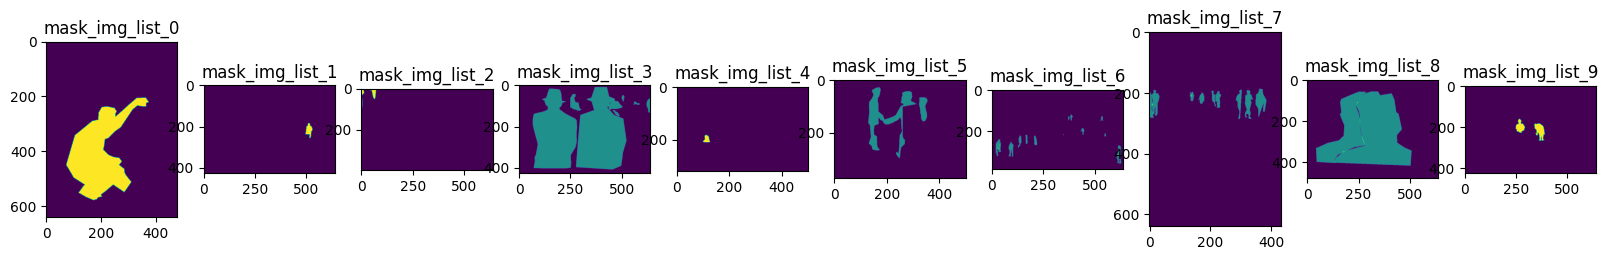

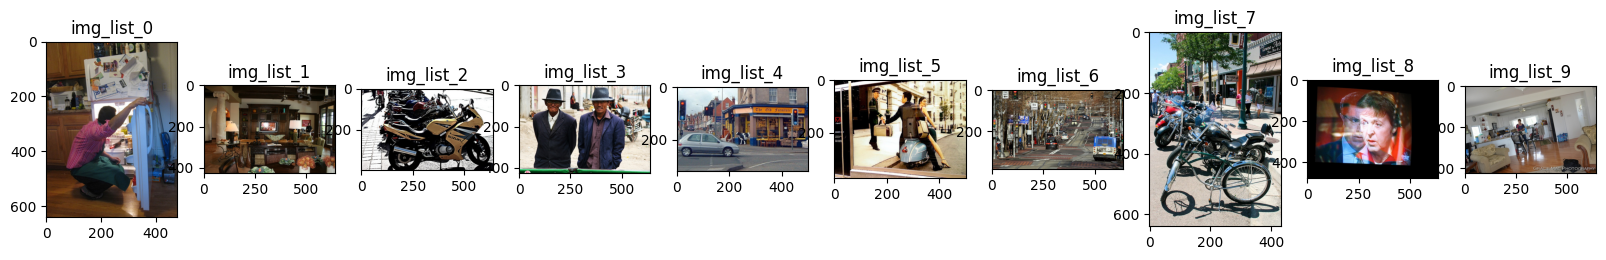

In [5]:
coco_annotation = COCO(json_list[0])
mask_img_list=[]
for i in range(len(person_image_id_list)):
    ann_ids = coco_annotation.getAnnIds(imgIds=[person_image_id_list[i]], iscrowd=None)
    anns = coco_annotation.loadAnns(ann_ids)
    mask = np.zeros(cv2.imread(img_list[i],0).shape)
    for j in range(len(anns)):
        mask += coco_annotation.annToMask(anns[j])
    # binary_mask =  mask * 255.
    mask_img_list.append(mask * 255.)


fig, axs = plt.subplots(nrows=1, ncols=10, figsize=(20, 8))
for i in range(len(mask_img_list)):
    axs[i].imshow(mask_img_list[i])
    axs[i].set_title("mask_img_list_"+str(i))

fig2, axs2 = plt.subplots(nrows=1, ncols=10, figsize=(20, 8))
for i in range(len(img_list)):
    axs2[i].imshow(cv2.cvtColor(cv2.imread(img_list[i]), cv2.COLOR_BGR2RGB))
    axs2[i].set_title("img_list_"+str(i))


## 3. data augmentation(using albumbentation) each image & mask or box

In [6]:
# 파이프라인을 사용해 1 -> N 개의 이미지와 mask&box를 만들어내는 함수

def aug_apply(task:str,image,mask_or_box,aug,iter=30,is_show=False):
    image_list = [image]
    label_list = [mask_or_box]
    showing_label_list = ['origin']

    for i in range(iter):
        if task == "seg" and len(mask_or_box) != 4:
            augment = aug(image=image, mask = mask_or_box)
            image_list.append(augment['image'])
            label_list.append(augment['mask'] )
        elif task == "od" and len(mask_or_box) == 4:
            augment = aug(image=image, bboxes = mask_or_box)
            image_list.append(augment['image'])
            label_list.append(augment['bboxes'] )    
    return image_list,label_list

In [7]:
# albumentation 데이터 증강 파이프라인 
# def aug_func(dataset_dir,output_dir,ea=512,task_type = seg,od)
transform = A.Compose([
    A.RandomCrop(height=256, width=256,p=0.5),
    A.HorizontalFlip(p=0.5),
    A.RandomRotate90(),
    A.RandomBrightnessContrast(brightness_limit=(-0.2, 0.3), contrast_limit=(-0.2, 0.3), p=0.5),
    A.RandomResizedCrop(height=256, width=256, scale=(0.4, 1.0),p = 0.5),
    A.OneOf([
        A.HueSaturationValue(p=0.5),
        A.Blur(p=0.5),
        A.CLAHE(p=0.5)
    ], p=0.8)
])
random.seed(42)
# for 1 image
images,masks = aug_apply("seg",cv2.cvtColor(cv2.imread(img_list[5]), cv2.COLOR_BGR2RGB),mask_img_list[5],transform,iter=20)

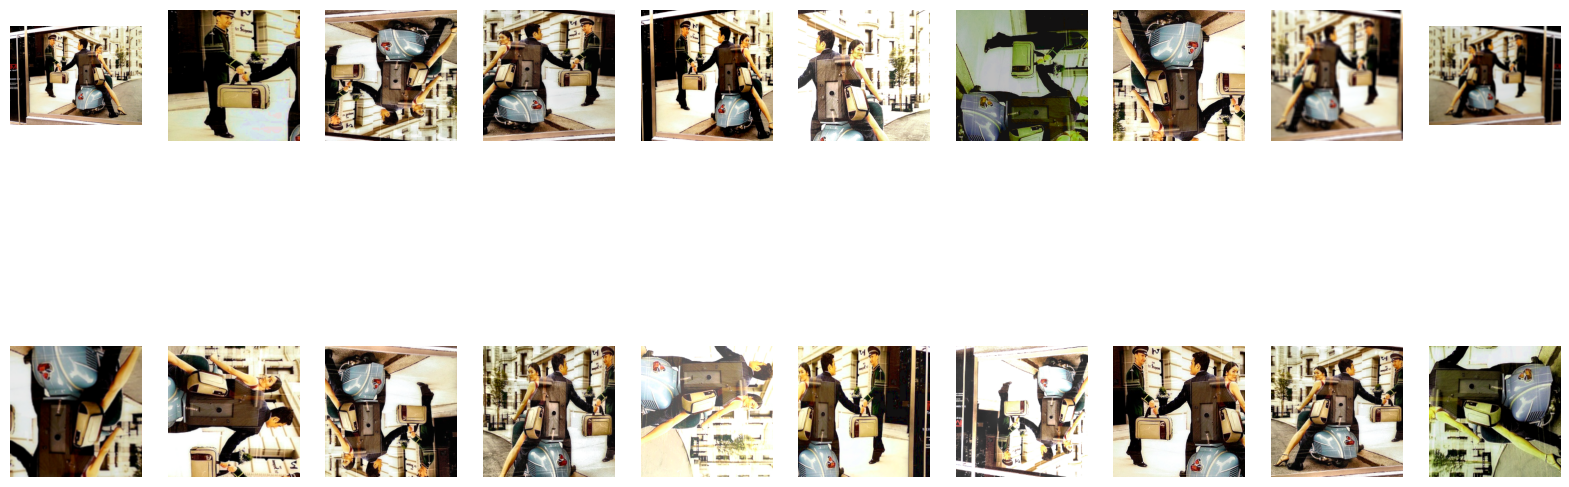

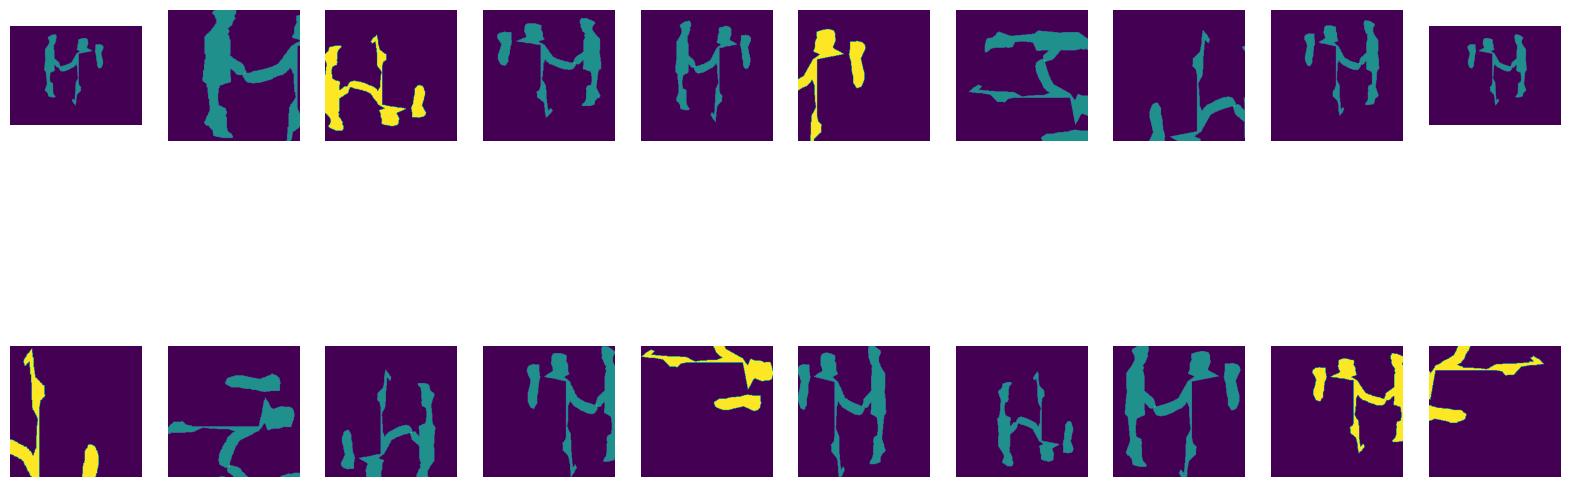

In [10]:
plt.figure(figsize=(20,8))
for index in range(20):
    plt.subplot(2,10,index+1)
    plt.imshow(images[index])
    plt.axis("off")


plt.figure(figsize=(20,8))
for index in range(20):
    plt.subplot(2,10,index+1)
    plt.imshow(masks[index])
    plt.axis("off")
    
plt.show()

## 4. check quality of augmented data 

In [11]:
def data_validation(image_list,mask_list):
    origin_image,augmented_image = image_list[0],image_list[1:-1]
    origin_mask,augmented_mask = mask_list[0], mask_list[1:-1]
    # get original mask ratio 
    full_area = origin_image.shape[0] * origin_image.shape[1] 
    origin_ma = np.where(origin_mask > 0,255,0)
    org_maskimg = origin_ma.astype(np.uint8)
    contours,hierachy = cv2.findContours(org_maskimg, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)   
    org_area = 0
    for cnt, cont in enumerate(contours):
        xmin,ymin,width,height = cv2.boundingRect(cont) #bounding box
        org_area += width*height
    
    original_mask_ratio = round((org_area / full_area),1)
    
    filtered_mask = []
    filtered_image = []
    filtered_idx = []
    for idx in range(len(augmented_mask)):
        ma = np.where(augmented_mask[idx] > 0,255,0)
        maskimg = ma.astype(np.uint8)
        contours,hierachy = cv2.findContours(maskimg, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        area = 0
        for cnt, cont in enumerate(contours):
            xmin,ymin,width,height = cv2.boundingRect(cont) #bounding box
            area += width*height
            
        if area > (original_mask_ratio * 0.5) : 
            filtered_mask.append(mask_list[idx])
            filtered_image.append(image_list[idx])
            filtered_idx.append(idx)
    
    return filtered_image, filtered_mask, filtered_idx
     

In [12]:
filtered_image, filtered_mask , filtered_idx = data_validation(images,masks)

(19,
 19,
 19,
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18])

## 5. save all images and coco-type annotation file(as 1 .json file) generated from augmented mask images to local

In [86]:
# save all augmented images to local (for single src image)
filenames = img_list[0].split("/")[-1]
path = os.getcwd()+"/user_dataset_sample/augmented_data/"
if os.path.isdir(os.getcwd()+"/user_dataset_sample/augmented_data/"):pass
else: os.mkdir(os.getcwd()+"/user_dataset_sample/augmented_data/")
for i in range(len(filtered_image)):
    cv2.imwrite(path+filenames.split(".")[0]+"_aug_"+str(i)+".jpg",cv2.cvtColor(filtered_image[i],cv2.COLOR_BGR2RGB))
    
    
# convert all mask to .json
form = coco_style_gen()
all_annos = 0
for i in range(len(filtered_mask)):
    tmp = filtered_mask[i].copy()
    #get contours of image
    tmp = tmp.astype(np.uint8)
    contours,hierachy = cv2.findContours(tmp, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    #black images to draw the contours on
    blank = np.zeros_like(tmp)

    for cnt, cont in enumerate(contours):
        segmentation = []
        xmin,ymin,width,height = cv2.boundingRect(cont) #bounding box
        if width * height < 3:
            continue
        image_height = filtered_mask[i].shape[0]
        image_width = filtered_mask[i].shape[1]
        
        #draw contour for verification
        # cv2.drawContours(empty, [cont], 0, 255, -1)

        cont = cont.flatten().tolist() #contour as 1d array has shape (x1,y1,x2,y2,...,x_n, y_n)
        #as in https://github.com/facebookresearch/Detectron/issues/100#issuecomment-362882830
        if len(cont) > 4: #only of at least 2 points are there
            segmentation.append(cont)
        else:
            continue
        if len(segmentation) == 0: #check again if segmentations are in list
            continue
        form["annotations"].append({'segmentation': segmentation,
                                      'area': width * height,
                                      'image_id': i,
                                      'iscrowd':0,
                                      'bbox': [xmin,ymin,width,height],
                                      "category_id": 0,
                                      "id": all_annos})
        all_annos += 1
        
    form['images'].append({'date_captured': '2021',
                              'file_name': path+filenames.split(".")[0]+"_aug_"+str(i)+".jpg",
                              'id': i,
                              'height': filtered_mask[i].shape[0],
                              'width': filtered_mask[i].shape[1]})

with open("aug_anno_test_2.json", "w") as handle:
    json.dump(form, handle)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
[8, 9]


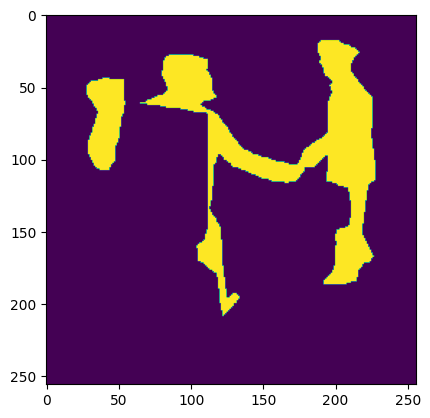

In [90]:
coco_annotation = COCO("/home/tbelldev/workspace/autoLabeling/api_test/aug_anno_test_2.json")
ann_ids = coco_annotation.getAnnIds(imgIds=[3], iscrowd=None)
print(ann_ids)
anns = coco_annotation.loadAnns(ann_ids)
mask = np.zeros(cv2.imread("/home/tbelldev/workspace/autoLabeling/api_test/user_dataset_sample/augmented_data/000000425226_aug_3.jpg",0).shape)
for i in range(len(anns)):
    mask += coco_annotation.annToMask(anns[i])
# mask += coco_annotation.annToMask(anns[1])
binary_mask =  mask * 255.
plt.imshow(binary_mask)
plt.show()


# augmentation.py

In [48]:
import albumentations as A
import random
import cv2
import numpy as np
import os
# from matplotlib import pyplot as plt

from glob import glob
import json
import shutil
import argparse

import pycocotools
from pycocotools.coco import COCO

import requests 
from PIL import Image

from datetime import date

def coco_style_gen():
    today = date.today()
    files = {}
    files['info'] = {"year": str(today.year), "version": "1.0", "description": "Person Segmentation", "date_created": str(today.month)+"/"+str(today.day)}
    files['licenses'] = [{'id': 1,
        'name': 'TBell - sslo general license v1',
        'url': 'https://sslo.ai/'}]
    files["type"] = "instances"
    files['categories'] = []
    files["annotations"] = []
    files['images'] = []
    return files

class augmentator:
    # user 정보를 활용하여 dataset의 위치를 특정 -> image와 json 파일을 불러옴
    def __init__(self,user_dataset_dir,output_dir,labeling_type = "seg",iter = 20):
        self.dataset_path = user_dataset_dir
        self.output_dir = output_dir
        self.task = labeling_type
        self.iter = iter
        self.img_list = [i for i in glob(self.dataset_path+"/*.jpg")]
        imsize_list = [cv2.imread(i).shape for i in self.img_list]
        width_list = [imsize_list[i][1] for i in range(len(imsize_list))]
        height_list = [imsize_list[i][0] for i in range(len(imsize_list))]
        self.min_image_size=(min(width_list),min(height_list))
        self.json_data = [i for i in glob(self.dataset_path+"/*.json")][0]
        self.aug = self.load_pipeline()
        self.cats = []
        self.image_id = 0
        self.form = coco_style_gen()
        self.all_annos = 0
        self.start()
    
    def load_pipeline(self):
        if self.task == "seg":
            transform = A.Compose([
            A.RandomCrop(width=int(self.min_image_size[0]*0.9), height=int(self.min_image_size[1]*0.9),p=0.5),
            A.HorizontalFlip(p=0.5),
            A.RandomRotate90(),
            A.RandomBrightnessContrast(brightness_limit=(-0.2, 0.3), contrast_limit=(-0.2, 0.3), p=0.5),
            A.OneOf([
                A.HueSaturationValue(p=0.5),
                A.Blur(p=0.5),
                A.CLAHE(p=0.5)
            ], p=0.8)
            ])
        elif self.task == "od":
            transform = A.Compose([
            A.RandomCrop(height=200, width=200,p=0.5),
            A.HorizontalFlip(p=0.5),
            A.RandomRotate90(),
            A.RandomBrightnessContrast(brightness_limit=(-0.2, 0.3), contrast_limit=(-0.2, 0.3), p=0.5),
            A.OneOf([
                A.HueSaturationValue(p=0.5),
                A.Blur(p=0.5),
                A.CLAHE(p=0.5)
            ], p=0.8)
            ],bbox_params=A.BboxParams(format='coco',label_fields = ['class_labels']))
        random.seed(42)
        
        return transform
    # 사용자가 업로드한 라벨 데이터는 coco 형식의 json 파일로써 한개만 존재한다고 가정       
    def start(self):
        coco_annotation = COCO(self.json_data)
        with open(self.json_data, 'r') as f: coco_data = json.load(f)
        imgids = coco_annotation.getImgIds()
        self.cats = coco_annotation.loadCats(coco_annotation.getCatIds())
        for i in range(len(imgids)):
            mask_list=[]
            cat_list = []
            
            box_list = []
            cls_name = []
            
            ann_ids = coco_annotation.getAnnIds(imgIds=[imgids[i]], iscrowd=None)
            anns = coco_annotation.loadAnns(ann_ids)
            
            img_file_name = [imginfo["file_name"] for imginfo in coco_data["images"] if imginfo["id"] == imgids[i]][0]
            for j in range(len(anns)):
                if self.task == 'seg':
                    cat_list.append(anns[j]["category_id"])
                    mask_list.append(coco_annotation.annToMask(anns[j]))
                elif self.task == 'od':
                    box_list.append(anns[j]["bbox"])
                    cat_list.append(anns[j]["category_id"])
                    cls_name.append([cat["name"] for cat in self.cats if anns[j]["category_id"] == cat["id"]][0])
                
                
            # images = [img1,img2,.....] / masks = [[mask1,mask2,mask3,....],[mask1,mask2,mask3,....],[mask1,mask2,mask3,....],......] masks의 각 인덱스는 images의 각 인덱스와 매핑됨,
            # masks[n] = [mask1,mask2,mask3,...] : img1 에 포함되어있는 class들의 마스크 즉, mask1 ~ maskn 은 cat_list의 인덱스와 매핑됨
            
            if self.task == 'seg':
                images,labels = self.aug_apply(cv2.cvtColor(cv2.imread(self.dataset_path+img_file_name), cv2.COLOR_BGR2RGB),mask_or_box = mask_list,iter=self.iter)
            elif self.task == 'od':
                images,labels,classes  = self.aug_apply(cv2.cvtColor(cv2.imread(self.dataset_path+img_file_name), cv2.COLOR_BGR2RGB),mask_or_box = box_list, cls_name = cls_name,iter=self.iter)
            
            self.save_imgs(img_file_name.split(".")[0],images)
            self.coco_form_write(img_file_name.split(".")[0],labels,cat_list)
        
        with open(self.output_dir+"/aug_anno_"+str(self.task)+"_"+str(self.iter)+".json", "w") as handle:
            json.dump(self.form, handle)
            
    def aug_apply(self,image,mask_or_box:list,cls_name = [],iter=20):
        image_list = [image]
        label_list =[mask_or_box]
        cls_list = [cls_name]
        for i in range(iter):
            if self.task == "seg":
                augment = self.aug(image=image, masks = mask_or_box)
                image_list.append(augment['image'])
                label_list.append(augment['masks'] )
                
            elif self.task == "od":
                augment = self.aug(image=image, bboxes = mask_or_box, class_labels = cls_name)
                image_list.append(augment['image'])
                label_list.append(augment['bboxes'])
                cls_list.append(augment['class_labels'])
                  
        if self.task == "seg": return image_list, label_list
        elif self.task == "od": return image_list, label_list, cls_list
      
    def save_imgs(self,filenames,images):
        # save all augmented images to local (for single src image)
        if os.path.isdir(self.output_dir):pass
        else: os.mkdir(self.output_dir)
        for i in range(len(images)):
            cv2.imwrite(self.output_dir+filenames.split(".")[0]+"_aug_"+str(i)+".jpg",cv2.cvtColor(images[i],cv2.COLOR_BGR2RGB))
    
    def coco_form_write(self,filenames,labels,cat_list):
        if self.task == "seg":
            for count ,mask in enumerate(labels):
                self.image_id +=1
                self.form['images'].append({'date_captured': '2022',
                                        'file_name': self.output_dir+filenames.split(".")[0]+"_aug_"+str(count)+".jpg",
                                        'id': self.image_id,
                                        'height': cv2.imread(self.output_dir+filenames.split(".")[0]+"_aug_"+str(count)+".jpg",0).shape[0],
                                        'width': cv2.imread(self.output_dir+filenames.split(".")[0]+"_aug_"+str(count)+".jpg",0).shape[1]})
            
                for cat in self.cats:
                    for id in range(len(cat_list)):
                        if cat["id"] == cat_list[id]:
                            if {'id':cat["id"],'name':cat["name"]} in self.form["categories"]:
                                pass
                            else:
                                self.form["categories"].append({'id':cat["id"],
                                                'name':cat["name"]})
                
                for i in range(len(mask)):
                    tmp = mask[i].copy()
                    #get contours of image
                    tmp = tmp.astype(np.uint8)
                    contours,hierachy = cv2.findContours(tmp, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)                
                    
                    for cnt, cont in enumerate(contours):
                            segmentation = []
                            xmin,ymin,width,height = cv2.boundingRect(cont) #bounding box
                            if width * height < 3:
                                continue
                            image_height = tmp.shape[0]
                            image_width = tmp.shape[1]

                            cont = cont.flatten().tolist() #contour as 1d array has shape (x1,y1,x2,y2,...,x_n, y_n)
                            if len(cont) > 4: #only of at least 2 points are there
                                segmentation.append(cont)
                            else:
                                continue
                            if len(segmentation) == 0: #check again if segmentations are in list
                                continue
                            if (width * height) > 100 :
                                self.form["annotations"].append({'segmentation': segmentation,
                                                'area': width * height,
                                                    'image_id': self.image_id,
                                                    'iscrowd':0,
                                                    'bbox': [xmin,ymin,width,height],
                                                    "category_id": cat_list[i],
                                                    "id": self.all_annos})                            
                                self.all_annos += 1
        elif self.task == "od":
            for count ,boxes in enumerate(labels):
                self.image_id +=1
                self.form['images'].append({'date_captured': '2022',
                                        'file_name': self.output_dir+filenames.split(".")[0]+"_aug_"+str(count)+".jpg",
                                        'id': self.image_id,
                                        'height': cv2.imread(self.output_dir+filenames.split(".")[0]+"_aug_"+str(count)+".jpg",0).shape[0],
                                        'width': cv2.imread(self.output_dir+filenames.split(".")[0]+"_aug_"+str(count)+".jpg",0).shape[1]})
            
                for cat in self.cats:
                    for id in range(len(cat_list)):
                        if cat["id"] == cat_list[id]:
                            if {'id':cat["id"],'name':cat["name"]} in self.form["categories"]:
                                pass
                            else:
                                self.form["categories"].append({'id':cat["id"],
                                                'name':cat["name"]})
                                
                for i in range(len(boxes)):                            
                    xmin,ymin,width,height = boxes[i][0],boxes[i][1],boxes[i][2],boxes[i][3] #bounding box
                    if width * height < 3:
                        continue
                    image_height = cv2.imread(self.output_dir+filenames.split(".")[0]+"_aug_"+str(count)+".jpg",0).shape[0]
                    image_width = cv2.imread(self.output_dir+filenames.split(".")[0]+"_aug_"+str(count)+".jpg",0).shape[1]

                    if (width * height) > 100 :
                        self.form["annotations"].append({'segmentation': [],
                                        'area': width * height,
                                            'image_id': self.image_id,
                                            'iscrowd':0,
                                            'bbox': [xmin,ymin,width,height],
                                            "category_id": cat_list[i],
                                            "id": self.all_annos})                            
                        self.all_annos += 1           

In [ ]:
user_dataset_dir = "/home/tbelldev/workspace/autoLabeling/api_test/user_dataset_sample/"
output_dir = "/home/tbelldev/workspace/autoLabeling/api_test/user_dataset_sample/augmented_data/"
augmentator(user_dataset_dir,output_dir,labeling_type = "od",iter = 5)